In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import pytz

import gm2
import trfp

central_time = pytz.timezone('US/Central')

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(7,4.33)})


Welcome to JupyROOT 6.12/04


In [2]:
class TrolleyRun(object):
    
    
    def __init__(self,run):
        self.fp = gm2.FixedProbe([run])
        self.tr = gm2.Trolley([run])
        
        tr_time, tr_phi, tr_freq = self.tr.getBasics(mode_phi=2)
        fp_id, fp_time, fp_freq = self.fp.getBasics()
        tr_time /= 1.0e9 # timestamps come in nanoseconds, convert to seconds
        fp_time /= 1.0e9
        
        times, tr_freq_interp, tr_phi_interp, fp_freq_interp = self.__time_interpolation(tr_time,
                                                                                         tr_phi,tr_freq,fp_time,fp_freq)
        
        cols = ["tr_phi"]+["tr"+str(i) for i in np.arange(17)]+["fp"+str(i) for i in np.arange(378)]
        data = np.append(np.append(tr_phi_interp,tr_freq_interp,axis=1),fp_freq_interp,axis=1)

        self.interp_data = pd.DataFrame(data, index=times, columns=cols)
        
        
    def __time_interpolation(self, tr_time,tr_phi,tr_freq,fp_time,fp_freq):
        tr_indices = np.mean(tr_freq,1)>0
        fp_indices = np.mean(fp_freq,1)>0

        tr_raw_times = tr_time[tr_indices]
        fp_raw_times = fp_time[fp_indices]

        first_time = np.ceil(np.max([tr_raw_times[0,16],fp_raw_times[0,377]]))
        last_time = np.floor(np.min([tr_raw_times[-1,0],fp_raw_times[-1,0]]))

        times = np.arange(first_time,last_time+1,1)

        tr_freq_interp = np.zeros([times.size,17])
        tr_phi_interp = np.zeros([times.size,1])
        fp_freq_interp = np.zeros([times.size,378])

        for i in np.arange(17):
            freq_interp = interp1d(tr_time[tr_indices][:,i], tr_freq[tr_indices][:,i], kind='slinear')
            tr_freq_interp[:,i] = freq_interp(times)
            phi_interp = interp1d(tr_time[tr_indices][:,i], np.rad2deg(np.unwrap(np.deg2rad(tr_phi[tr_indices][:,i]))), 
                                  kind='slinear')
            tr_phi_interp[:,0] += phi_interp(times)/17

        for i in np.arange(378):
            freq_interp = interp1d(fp_time[fp_indices][:,i], fp_freq[fp_indices][:,i], kind='slinear')
            fp_freq_interp[:,i] = freq_interp(times)

        return times, tr_freq_interp, tr_phi_interp, fp_freq_interp
    

class FixedProbeRun(object):
    
    def __init__(self,run):
        self.fp = gm2.FixedProbe([run])
        
        fp_id, fp_time, fp_freq = self.fp.getBasics()
        fp_time /= 1.0e9
        
        times, fp_freq_interp = self.__time_interpolation(fp_time, fp_freq)
        
        cols = ["fp"+str(i) for i in np.arange(378)]
        
        self.interp_data = pd.DataFrame(fp_freq_interp, index=times, columns=cols)
        
    def __time_interpolation(self, fp_time, fp_freq):
        fp_indices = np.mean(fp_freq, 1)>0
        fp_raw_times = fp_time[fp_indices]

        first_time = np.ceil(fp_raw_times[0,377])
        last_time = np.floor(fp_raw_times[-1,0])

        times = np.arange(first_time,last_time+1,2)

        fp_freq_interp = np.zeros([times.size,378])

        for i in np.arange(378):
            freq_interp = interp1d(fp_time[fp_indices][:,i], fp_freq[fp_indices][:,i], kind='slinear')
            fp_freq_interp[:,i] = freq_interp(times)

        return times, fp_freq_interp

In [3]:
tr3956 = TrolleyRun(3956)

Reading event 8780/8781 99.99%    
loop done: 100%                                    
Reading event 2630/2634 99.85%   
loop done: 100%                                    


In [4]:
# for each station, find the peaks of the trolley effect in the barcode basis

# first step is to create fixed probe m-vectors as a function of time

geometry = trfp.Geometry()
field_to_moment_matrix = trfp.FieldToMomentMatrix()

theta_fp_6 = field_to_moment_matrix.theta_fp_6
theta_fp_4 = field_to_moment_matrix.theta_fp_4

In [5]:
stations = ['fp'+str(fp) for fp in geometry.station_probe_id[0]]

test = tr3956.interp_data[stations].copy()

fp_st_m = np.zeros([test.shape[0],6])

for ii in np.arange(test.shape[0]):
    if test.shape[1] == 6:
        fp_st_m[ii,:] = np.dot(theta_fp_6,test.iloc[ii])
    elif test.shape[1] == 4:
        fp_st_m[ii,0:3] = np.dot(theta_fp_4,test.iloc[ii])
        fp_st_m[ii,4:5] = [np.nan,np.nan]
    

In [6]:
print test.head()
print '\n'
print fp_st_m

                       fp0           fp1           fp2          fp18  \
1.524375e+09  45016.191610  50071.927185  54520.285640  56123.227965   
1.524375e+09  45016.821429  50072.219575  54520.302579  56122.101963   
1.524375e+09  45017.318399  50074.148276  54520.291367  56123.170505   
1.524375e+09  45018.440645  50072.548916  54520.241985  56123.457430   
1.524375e+09  45019.321118  50070.761637  54520.169709  56122.631650   

                      fp19          fp20  
1.524375e+09  52811.642911  46958.756969  
1.524375e+09  52810.590132  46960.056082  
1.524375e+09  52811.236640  46962.819895  
1.524375e+09  52811.990516  46963.610298  
1.524375e+09  52812.938280  46959.695487  


[[50917.00538012   127.3586378    612.19708537 -4091.32512764
  -3542.2627573  -1271.4920869 ]
 [50917.01529325   128.03822576   612.01992799 -4090.65933336
  -3539.62952988 -1270.03468513]
 [50918.16418033   128.48338455   612.22100619 -4090.17643355
  -3540.56587574 -1266.14840581]
 ...
 [50921.86604038 

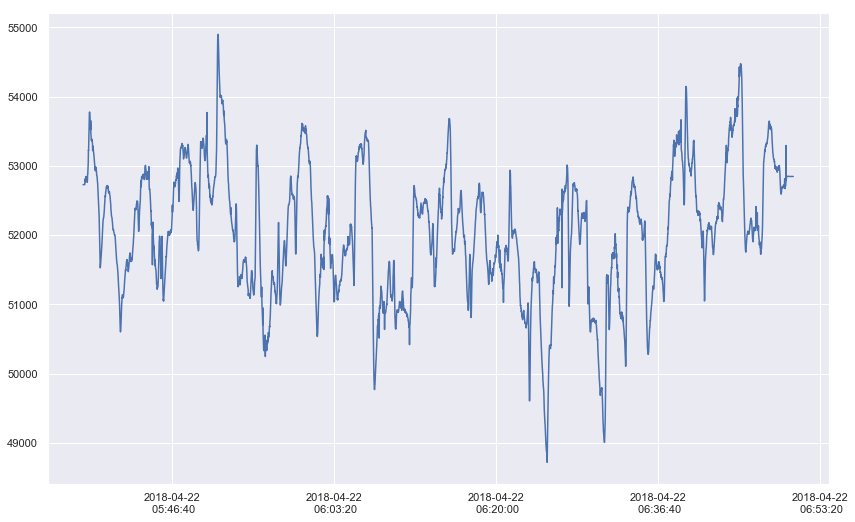

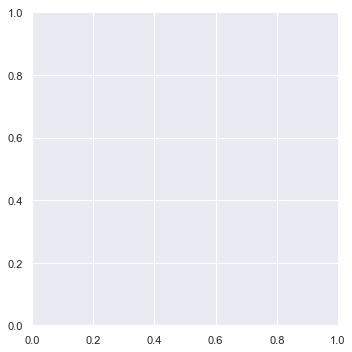

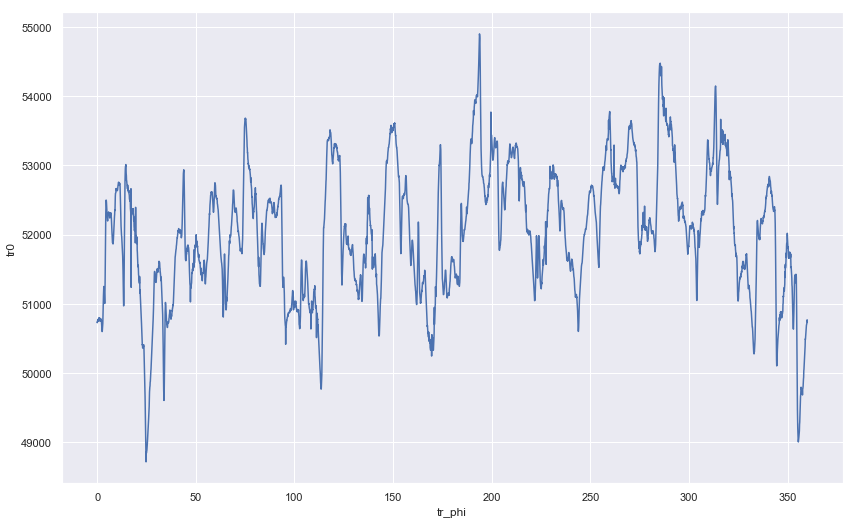

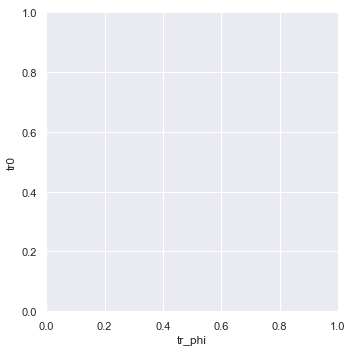

In [8]:
fig = plt.figure()
ax = plt.gca()
sns.relplot(data=tr3956.interp_data['tr0'],kind='line',ax=ax)
fig.set_size_inches(14, 8.66)
xticks = ax.get_xticks()
ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks],rotation=0)

pos_data = tr3956.interp_data.loc[:,['tr_phi','tr0']].copy()
pos_data['tr_phi'] = pos_data['tr_phi']%360

fig = plt.figure()
ax = plt.gca()
sns.relplot(x = 'tr_phi', y = 'tr0', data = pos_data, kind = 'line', ax = ax)
fig.set_size_inches(14, 8.66)
